In [1]:
import chainer

C:\Users\manab\anaconda3\Lib\site-packages\cupy\_environment.py:445: UserWarning: 
cudnn library could not be loaded.

Reason: ImportError (DLL load failed while importing cudnn: 指定されたモジュールが見つかりません。)

You can install the library by:
  $ conda install -c conda-forge cudnn

  warnings.warn(f'''
C:\Users\manab\anaconda3\Lib\site-packages\chainer\backends\cuda.py:154: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  warnings.warn(
C:\Users\manab\anaconda3\Lib\site-packages\chainer\_environment_check.py:72: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy) version 13.3.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
-----------------------

In [2]:
import cupy

In [3]:
import sys
print(sys.version)

3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]


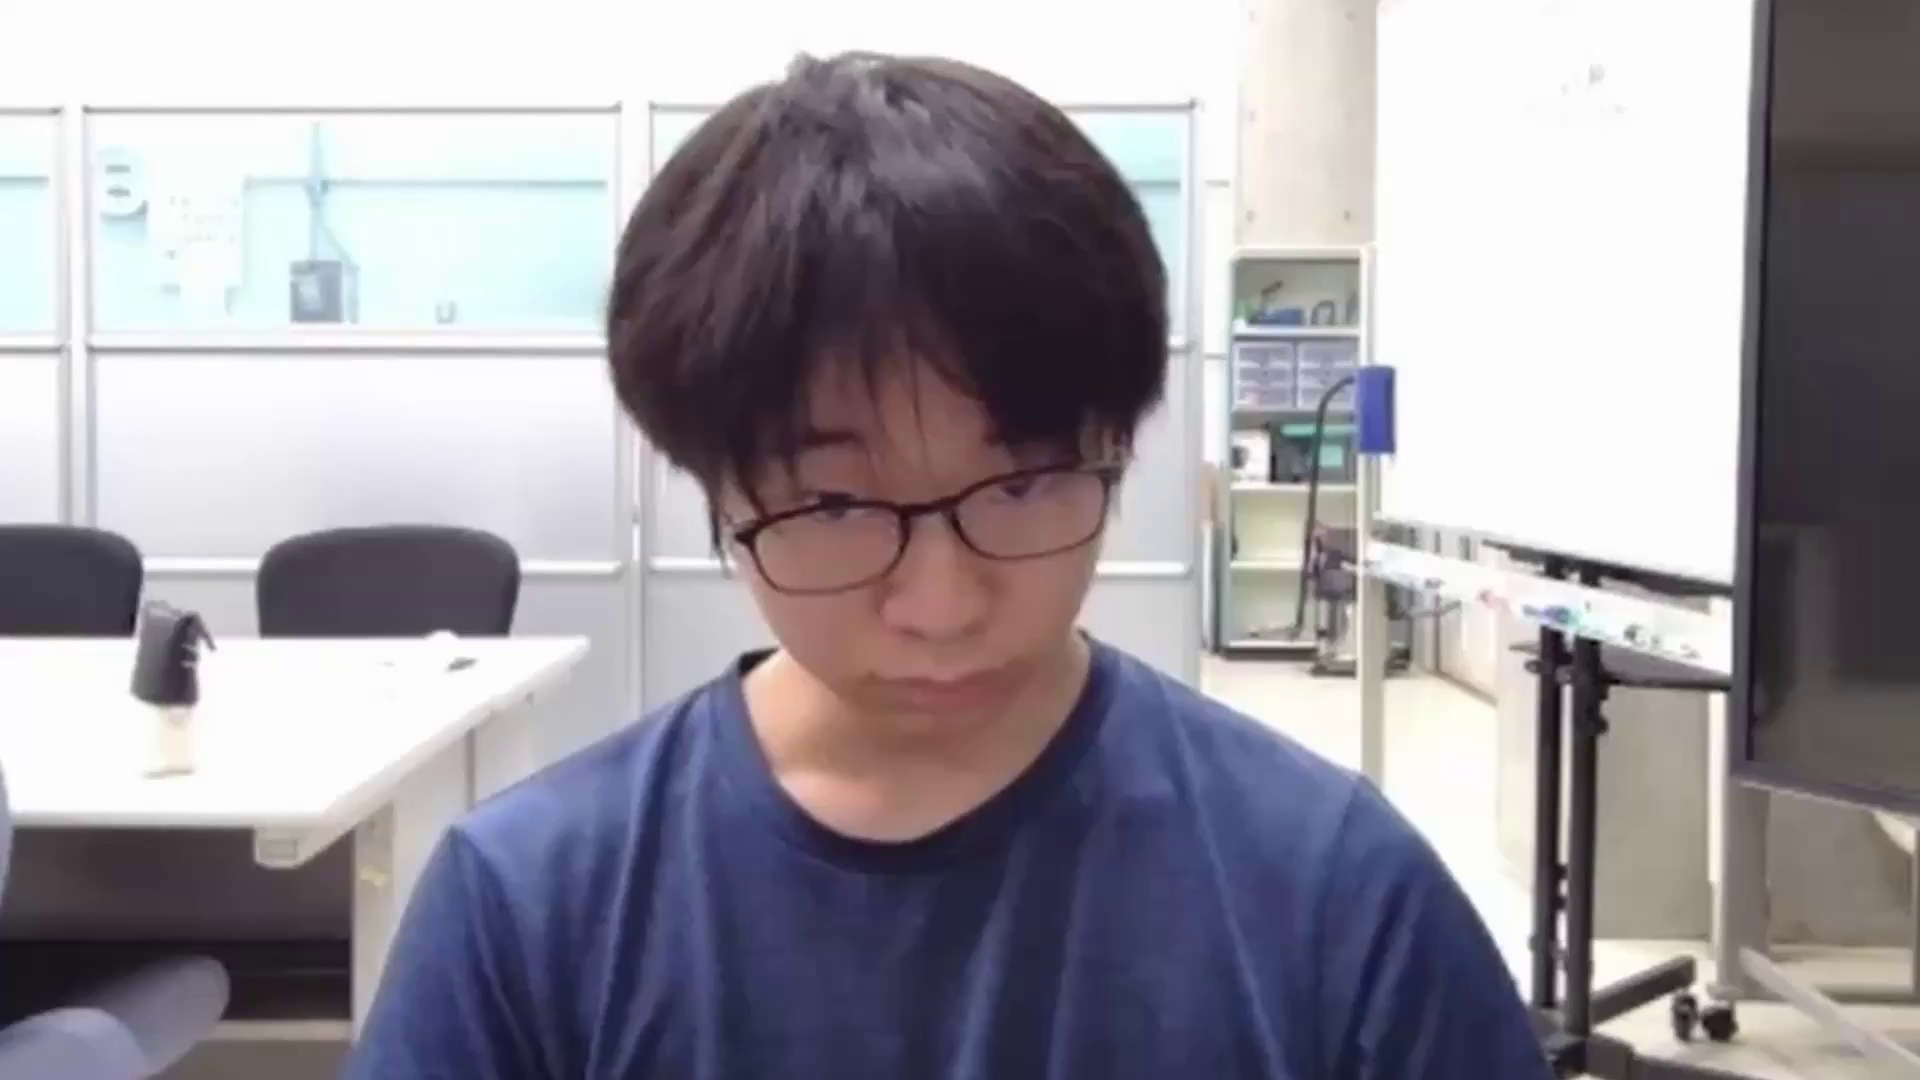

In [4]:
from PIL import Image

train_image_path = './Dataset/train/Abnormaly2800/Abnormaly_reaction_img_0000.jpg'
Image.open(train_image_path)

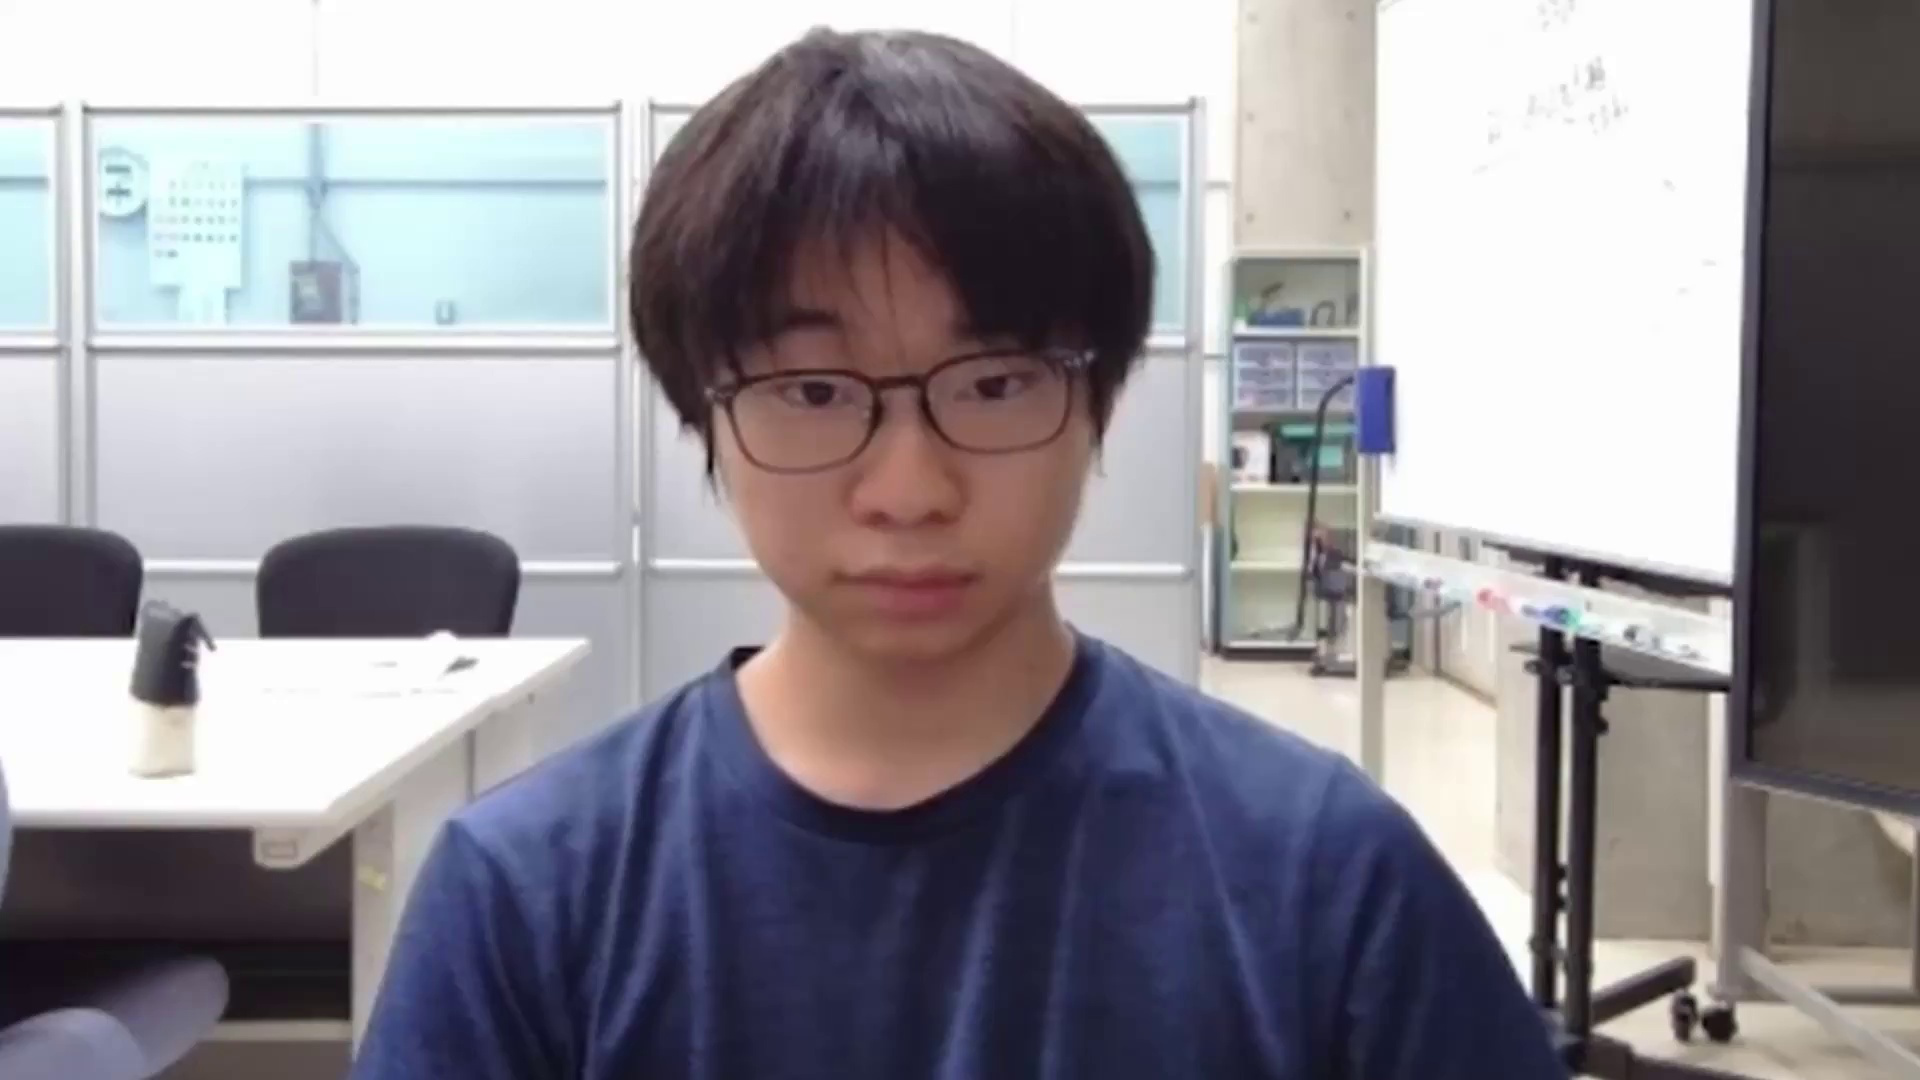

In [5]:
from PIL import Image

train_image_path = './Dataset/train/normal2800/normal_reaction_img_0000.jpg'
Image.open(train_image_path)

学習用データと検証用データを分ける

In [7]:
cats_images_train_path='Dataset/train/normal2800/'
dogs_images_train_path='Dataset/train/Abnormaly2800/'
cats_images_valid_path='Dataset/test/normal200/'
dogs_images_valid_path='Dataset/test/Abnormaly200/'

image_and_teacher_label_list=[]

関数の定義 get_image_teacher_label_list()の定義

In [9]:
import os

def get_image_teacher_label_list(dir, label):
  filepath_list = []
  files = os.listdir(dir)
  for file in files:
    filepath_list.append((dir + file, label))
  return filepath_list

学習と検証データをリストにする

In [11]:
# 学習データ猫の画像のフォルダ、ラベルは０：猫です
image_and_teacher_label_list.extend(get_image_teacher_label_list(cats_images_train_path, 0))
# 学習データ犬の画像のフォルダ、ラベルは１：犬です
image_and_teacher_label_list.extend(get_image_teacher_label_list(dogs_images_train_path, 1))
# 検証データ猫の画像のフォルダ、ラベルは０：猫です
image_and_teacher_label_list.extend(get_image_teacher_label_list(cats_images_valid_path, 0))
# 検証データ犬の画像のフォルダ、ラベルは１：犬です
image_and_teacher_label_list.extend(get_image_teacher_label_list(dogs_images_valid_path, 1))

In [12]:
print(image_and_teacher_label_list)

[('Dataset/train/normal2800/normal_reaction2_img_0000.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0001.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0002.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0003.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0004.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0005.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0006.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0007.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0008.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0009.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0010.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0011.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0012.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0013.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0014.jpg', 0), ('Dataset/train/normal2800/normal_reaction2_img_0015.j

画像データ形式の整備

In [14]:
import numpy as np

# 画像データをChainerのConvolution2Dに使えるように整備します
# 最後を先頭(x,y,color) => (color,x,y)
def data_reshape(width_height_channel_image):
  image_array = np.array(width_height_channel_image)
  return image_array.transpose(2, 0, 1)

画像を全部リサイズする

In [16]:
# 使用する画像が128×128以上でないとこのプログラムは動かない
INPUT_WIDTH = 128
INPUT_HEIGHT = 128

データ形状変換の結果確認

In [18]:
import cv2
import matplotlib.pyplot as plt

# 配列形状変換する前の画像データのshape （画像の幅、高さ、チャンネル）
image_before_reshape= cv2.imread('./Dataset/train/Abnormaly2800/Abnormaly_reaction_img_0114.jpg')
size=image_before_reshape.shape
print(size)

# 配列形状変換した後の画像データのshape
image_after_reshape = data_reshape(image_before_reshape)
print(image_after_reshape.shape)

(1080, 1920, 3)
(3, 1080, 1920)


画像の前処理関数

In [20]:
def adapt_data_to_convolution2d_format(input_image):
  image , label = input_image
  
  # image のデータを8ビットの符号なし整数に変換します
  image = image.astype(np.uint8)
  # Chainerの中データを用意する段階で、image.transpose(2, 0, 1)しましたので、（最後を先頭 (x,y,color)=> (color,x,y))
  # 正しくリサイズできるため、一回データの構造を戻して（先頭を最後に => (x,y,color))
  image = Image.fromarray(image.transpose(1, 2, 0))

  # 共通の画像のリサイズ処理です。第5章の１番目のレシピを参照してください
  result_image = image.resize((INPUT_WIDTH, INPUT_HEIGHT), Image.LANCZOS)
  
  # リサイズしたら、画像データをChainerのConvolution2Dに使えるように戻します（もう一回最後を先頭に  => (color,x,y))
  image = data_reshape(result_image)
  
  # データを0～1の間の値に変換します
  image = image.astype(np.float32) / 255

  return image, label

データセットの作成

In [22]:
from chainer.datasets import LabeledImageDataset
dogscats_dataset= LabeledImageDataset(image_and_teacher_label_list)

In [23]:
from chainer.datasets import TransformDataset
transformed_dataset = TransformDataset(dogscats_dataset, adapt_data_to_convolution2d_format)

学習用データと検証用データを分ける

In [25]:
from chainer import datasets

# 前処理済のデータを分けます
train_data, test_data= datasets.split_dataset_random(transformed_dataset, int(len(transformed_dataset) * 0.8), seed=0)

In [26]:
print(int(len(transformed_dataset) * 0.8))
print(len(train_data))
print(len(test_data))

4800
4800
1200


In [27]:
print(train_data)

In [28]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training,serializers,Chain,datasets,sequential,optimizers,iterators
from chainer.training import extensions,Trainer

In [29]:
GPU_ID = 0
BATCH_SIZE = 64
MAX_EPOCH = 10

CNNを設定する

In [31]:
class CNN(Chain):
  # コンストラクタ
  def __init__(self):
    super(CNN, self).__init__()

    with self.init_scope():
      self.conv1 = L.Convolution2D(None, out_channels=32, ksize=3, stride=1, pad=1)
      self.conv2 = L.Convolution2D(in_channels=32, out_channels=64, ksize=3, stride=1, pad=1)
      self.conv3 = L.Convolution2D(in_channels=64, out_channels=128, ksize=3, stride=1, pad=1)
      self.conv4 = L.Convolution2D(in_channels=128, out_channels=256, ksize=3, stride=1, pad=1)
      self.layer1 = L.Linear(None, 1000)
      self.layer2 = L.Linear(1000, 2)
  #
  def __call__(self, input):
    func = F.max_pooling_2d(F.relu(self.conv1(input)), ksize=2, stride=2)
    func = F.max_pooling_2d(F.relu(self.conv2(func)), ksize=2, stride=2)
    func = F.max_pooling_2d(F.relu(self.conv3(func)), ksize=2, stride=2)
    func = F.max_pooling_2d(F.relu(self.conv4(func)), ksize=2, stride=2)
    # func = F.dropout(F.relu(self.layer1(func)), ratio=0.80)
    func = F.dropout(F.relu(self.layer1(func)), ratio=0.5)
    func = self.layer2(func)
    return func

In [32]:
model = L.Classifier(CNN())
model.to_gpu(GPU_ID)

反復子

In [34]:
# # 学習用の反復子
# train_iterator = iterators.MultiprocessIterator(train_data, BATCH_SIZE)
# # 検証用の反復子
# test_iterator = iterators.MultiprocessIterator(test_data, BATCH_SIZE, False, False)
train_iterator = iterators.SerialIterator(train_data, BATCH_SIZE)
test_iterator = iterators.SerialIterator(test_data, BATCH_SIZE, repeat=False, shuffle=False)

Optimizerの設定

In [36]:
optimizer = optimizers.Adam().setup(model)

updaterの設定

In [38]:
# updater = training.StandardUpdater(train_iterator, optimizer, device=GPU_ID)
updater = training.StandardUpdater(train_iterator, optimizer, device=0)

trainerの設定

In [40]:
trainer = Trainer(updater, stop_trigger=(MAX_EPOCH, 'epoch'))

extensionsの設定

In [42]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.Evaluator(test_iterator, model, device=GPU_ID), name='validation')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))

# レポートのグラフを出力するextension
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', marker='^', grid=True, file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch',marker='^' , grid=True, file_name='accuracy.png'))

学習の実行

In [44]:
# trainer.run()

学習結果の確認

正解率（Accuracy）

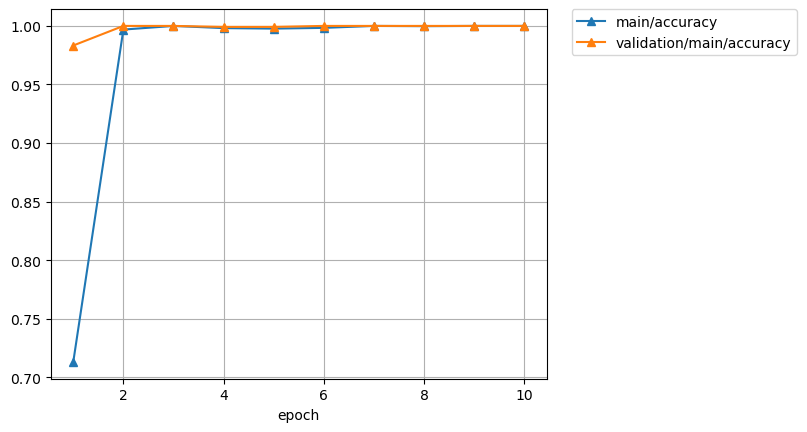

In [47]:
Image.open('result/accuracy.png')

誤差

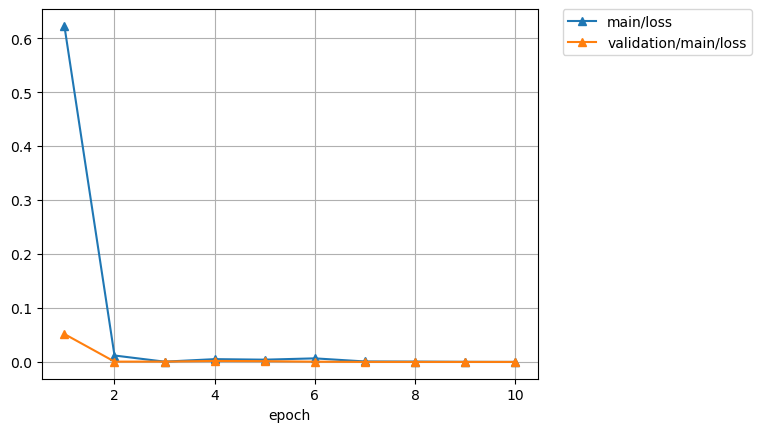

In [49]:
Image.open('result/loss.png')

検証する(学習済みモデルを使う)

モデルを書き出す

In [52]:
# serializers.save_hdf5("normal-or-Abnormaly-model_0930.h5", model)

モデルを読み込む

In [54]:
serializers.load_hdf5("normal-or-Abnormaly-model_0930.h5", model)

RuntimeError: h5py is not installed on your environment.
Please install h5py to activate hdf5 serializers.

  $ pip install h5py

ここから学習済モデルを使う

関数の定義 convert_test_data()

In [ ]:
def convert_test_data(image_file_path, size, show=False):

  image = Image.open(image_file_path)

  # 共通の画像のリサイズ処理です。第5章の１番目のレシピを参照してください
  result_image = image.resize((INPUT_WIDTH, INPUT_HEIGHT), Image.LANCZOS)
  
  # 画像データをChainerのConvolution2Dに使えるように整備します
  image = data_reshape(result_image)

  # 型をfloat32に変換します
  result = image.astype(np.float32)
  # 学習済みモデルに渡します
  result = model.xp.asarray(result)
  # モデルに渡すデータフォーマットに変換します
  result = result[None, ...]
  return result

検証用の写真を選ぶ

画像のサイズの設定

In [ ]:
INPUT_WIDTH = 128
INPUT_HEIGHT = 128

In [ ]:
test_image_url='./Dataset/test/normal200/normal_reaction_img_1239.jpg'
# test_image_url='./Dataset/test/Abnormaly200/Abnormaly_reaction_img_0016.jpg'
# test_image_url='./Dataset/test/normal200/normal_reaction2_img_0505.jpg'
# test_image_url='./Dataset/test/Abnormaly200/Abnormaly_reaction2_img_1799.jpg'

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
image_path = test_image_url
Image.open(image_path)

In [ ]:
from chainer.cuda import to_cpu
# 学習時と同じ画像のサイズにしなければいけません
test_data= convert_test_data(test_image_url, (INPUT_WIDTH, INPUT_HEIGHT))
with chainer.using_config('train', False), chainer.using_config(
            'enable_backprop', False):
  test_teacher_labels = model.predictor(test_data)
  test_teacher_labels = to_cpu(test_teacher_labels.array)
  test_teacher_label = test_teacher_labels.argmax(axis=1)[0]
  if test_teacher_label == 0:
    retval = 'normal'
  else:
    retval = 'Abnormaly'

print(retval)